In [15]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [16]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


# calculate recall, roc_auc, accuracy, precision, and f1 scores
def calculate_metrics(clf, X, y):
    y_pred = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)[:, 1]
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # print all scores
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1: {f1:.4f}")
    return

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from utils.constants import SEED

from select_models import baseline_models, model_needs_scaling, timing_decorator

# baseline_models = [
#     LogisticRegression(random_state=SEED),
#     KNeighborsClassifier(),  # no random_state
#     SVC(
#         probability=True, random_state=SEED
#     ),  # probability=True needed for roc_auc_score
#     GaussianNB(),
#     BernoulliNB(),
#     GaussianProcessClassifier(random_state=SEED),
#     DecisionTreeClassifier(random_state=SEED),
#     RandomForestClassifier(random_state=SEED),
#     GradientBoostingClassifier(random_state=SEED),
#     AdaBoostClassifier(random_state=SEED),
#     ExtraTreesClassifier(random_state=SEED),
#     BaggingClassifier(random_state=SEED),
#     XGBClassifier(random_state=SEED),
# ]

# model_needs_scaling = [
#     "LogisticRegression",
#     "KNeighborsClassifier",
#     "SVC",
#     "GaussianProcessClassifier",  # might benefit from scaling (it does)
# ]


def load_data(target_type='bear', split_type='std'):
    """
    Loads data based on the specified target type and split type.

    Parameters:
    - target_type (str): Type of the target variable ('bear' or 'regime').
    - split_type (str): Type of the split ('std' or 'date').

    Returns:
    - X_train, y_train, X_test, y_test: Loaded datasets.
    """
    base_path = "split_data/"
    X_train_file = f"X_train_{target_type}_{split_type}.csv"
    y_train_file = f"y_train_{target_type}_{split_type}.csv"
    X_test_file = f"X_test_{target_type}_{split_type}.csv"
    y_test_file = f"y_test_{target_type}_{split_type}.csv"
    
    X_train = pd.read_csv(base_path + X_train_file)
    y_train = pd.read_csv(base_path + y_train_file)
    X_test = pd.read_csv(base_path + X_test_file)
    y_test = pd.read_csv(base_path + y_test_file)

    # Drop the USREC column from X_train and X_test
    X_train = X_train.drop(columns=["USREC"])
    X_test = X_test.drop(columns=["USREC"])
    
    print(f"Loaded {X_train_file}, {y_train_file}, {X_test_file}, and {y_test_file}.")
    return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()


def train_classifier(model, X_train, y_train):
    clf = model
    clf.fit(X_train, y_train)
    return clf

def create_correlation_matrix(X):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    return corr

def perform_hierarchical_clustering(corr):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    return dist_linkage

def plot_dendrogram(X, ax):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax, leaf_rotation=90)
    return dendro

def plot_heatmap(corr, dendro, ax):
    ax.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax.set_xticks(np.arange(0, len(dendro["ivl"])))
    ax.set_yticks(np.arange(0, len(dendro["ivl"])))
    ax.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro["ivl"])

# Using the functions
# X_train, y_train, X_test, y_test = load_data()
# clf = train_classifier(X_train, y_train)
# X = pd.concat([X_train, X_test], axis=0, ignore_index=True) # X is just for the correlation matrix, it's not used for training

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# dendro = plot_dendrogram(X, ax1)
# corr = spearmanr(X).correlation
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# plot_heatmap(corr, dendro, ax2)
# _ = fig.tight_layout()


In [18]:
from collections import defaultdict
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X))

def select_features_by_cluster(X, dist_linkage, threshold=1):
    """
    Select features based on a hierarchical clustering of the Spearman rank correlations.
    The threshold parameter allows to control the number of selected features.

    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    dist_linkage : np.ndarray
        The linkage matrix for the hierarchical clustering.
    threshold : float, default=1
        The threshold to apply when forming flat clusters.

    Returns
    -------
    selected_features : list
        The list of selected features.
    """

    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return X.columns[selected_features]

def calculate_permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    """
    Calculate the permutation importance of the features. This function wraps the scikit-learn
    permutation_importance function and returns the result.

    Parameters
    ----------
    clf : object
        The classifier object.
    X : pd.DataFrame
        The input data.
    y : pd.Series
        The target labels.
    n_repeats : int, default=10
        The number of times to permute a feature.
    random_state : int, default=42
        The random state for reproducibility.
    n_jobs : int, default=-1
        The number of jobs to run in parallel.   
    """
    result = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    return result

def filter_features_by_importance(X, perm_importance, threshold=0.005):
    """
    Filter the features based on the permutation importance. This function returns the feature
    names that have an importance measure greater than the threshold. 

    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    perm_importance : object
        The result of the permutation_importance function.
    threshold : float, default=0.01
        The threshold to use for feature selection.

    Returns
    -------
    important_features : list
        The list of important features.    
    """
    important_feature_indices = np.where(perm_importance.importances_mean >= threshold)[0]
    important_features = X.columns[important_feature_indices]
    return important_features


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


# # Usage of the functions
# selected_features_names = select_features_by_cluster(X, dist_linkage)

# X_train_sel = X_train[selected_features_names]
# X_test_sel = X_test[selected_features_names]

# clf_sel = train_classifier(X_train_sel, y_train)





In [19]:
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    metrics = {
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, predictions),
        'precision': precision_score(y_test, predictions),
        'accuracy': accuracy_score(y_test, predictions),
        'f1': f1_score(y_test, predictions),
    }
    # Calculate the average metric score
    average_score = np.mean(list(metrics.values()))
    return metrics, average_score


def optimize_and_evaluate(models, target_types, split_types, n_iterations_range=[5]):
    best_scores = {}
    best_features = {}
    
    for target in target_types:
        for split in split_types:
            X_train, y_train, X_test, y_test = load_data(target, split)
            
            # Combine datasets if needed for a comprehensive correlation matrix
            X_full = pd.concat([X_train, X_test])
            y_full = np.concatenate([y_train, y_test])
            
            # Shuffle the full dataset to avoid bias in feature selection
            X_full_shuffled, y_full_shuffled = shuffle(X_full, y_full, random_state=42)
            
            for model in models:
                model_name = type(model).__name__
                print(f"Evaluating {model_name} on target: {target}, split: {split}")
                
                best_model_score = 0
                best_iteration_features = None
                
                for n_iterations in n_iterations_range:
                    # Reset to full shuffled features for each iteration range start
                    current_features = X_full_shuffled.columns.tolist()
                    print(f"Starting iteration range: {n_iterations}")

                    
                    for iteration in range(n_iterations):
                        # Subset the train and test sets with the current features
                        X_train_sel = X_train[current_features]
                        X_test_sel = X_test[current_features]
                        
                        # Train the classifier with selected features
                        clf = train_classifier(model, X_train_sel, y_train)
                        
                        # Calculate permutation importance and refine features based on importance
                        perm_importance = calculate_permutation_importance(clf, X_train_sel, y_train)
                        important_features = filter_features_by_importance(X_train_sel, perm_importance)
                        
                        # Update current features based on importance for next iteration
                        current_features = important_features

                        # If no features are deemed important, break from the loop
                        if not important_features:
                            break
                    
                    # Evaluate the model with the refined features
                    _, average_score = evaluate_model(clf, X_test[current_features], y_test)
                    
                    if average_score > best_model_score:
                        best_model_score = average_score
                        best_iteration_features = current_features
                
                # Update best scores and features for each model after all iterations
                best_scores[f"{model_name}_{target}_{split}"] = best_model_score
                best_features[f"{model_name}_{target}_{split}"] = best_iteration_features

                print(f"Finished evaluating {model_name} on target: {target}, split: {split}")
                print(f"Best scores: {best_scores}")
                print(f"Best features: {best_features}")

    return best_scores, best_features


In [20]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def load_data(target_type='bear', split_type='std'):
    """
    Loads data based on the specified target type and split type.

    Parameters:
    - target_type (str): Type of the target variable ('bear' or 'regime').
    - split_type (str): Type of the split ('std' or 'date').

    Returns:
    - X_train, y_train, X_test, y_test: Loaded datasets.
    """
    base_path = "split_data/"
    X_train_file = f"X_train_{target_type}_{split_type}.csv"
    y_train_file = f"y_train_{target_type}_{split_type}.csv"
    X_test_file = f"X_test_{target_type}_{split_type}.csv"
    y_test_file = f"y_test_{target_type}_{split_type}.csv"
    
    X_train = pd.read_csv(base_path + X_train_file)
    y_train = pd.read_csv(base_path + y_train_file)
    X_test = pd.read_csv(base_path + X_test_file)
    y_test = pd.read_csv(base_path + y_test_file)
    
    # Drop the USREC column from X_train and X_test
    X_train = X_train.drop(columns=["USREC"]) # maybe do this in the split_data script?
    X_test = X_test.drop(columns=["USREC"])

    print(f"Loaded {X_train_file}, {y_train_file}, {X_test_file}, and {y_test_file}.")
    return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()

def perform_hierarchical_clustering(corr):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    return dist_linkage

def create_correlation_matrix(X):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    return corr

def select_features_by_cluster(X, dist_linkage, threshold=1):
    """
    Select features based on a hierarchical clustering of the Spearman rank correlations.
    The threshold parameter allows to control the number of selected features.

    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    dist_linkage : np.ndarray
        The linkage matrix for the hierarchical clustering.
    threshold : float, default=1
        The threshold to apply when forming flat clusters.

    Returns
    -------
    selected_features : list
        The list of selected features.
    """

    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return X.columns[selected_features]

def calculate_permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    """
    Calculate the permutation importance of the features. This function wraps the scikit-learn
    permutation_importance function and returns the result.

    Parameters
    ----------
    clf : object
        The classifier object.
    X : pd.DataFrame
        The input data.
    y : pd.Series
        The target labels.
    n_repeats : int, default=10
        The number of times to permute a feature.
    random_state : int, default=42
        The random state for reproducibility.
    n_jobs : int, default=-1
        The number of jobs to run in parallel.   
    """
    result = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    return result

def filter_features_by_importance(X, perm_importance, threshold=0.005):
    important_feature_indices = np.where(perm_importance.importances_mean >= threshold)[0]
    important_features = X.columns[important_feature_indices]
    return important_features

def train_classifier(X, y, model):
    # Train the model and return it
    model.fit(X, y)
    return model

def get_metrics(model, X_test, y_test):
    # Implement the logic to calculate and return the model metrics
    predictions = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions, average='macro', zero_division=0),
        'recall': recall_score(y_test, predictions, average='macro'),
        'f1_score': f1_score(y_test, predictions, average='macro'),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    return metrics

def scale_data(X_train, X_test=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    
    # Convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) if X_test is not None else None
    
    return X_train_scaled_df, X_test_scaled_df


def optimize_and_evaluate(models, target_types, split_types, n_iterations=5):
    best_scores = {}
    best_features = {}
    
    for target in target_types:
        for split in split_types:
            X_train, y_train, X_test, y_test = load_data(target, split)
            X_full = pd.concat([X_train, X_test])

            for model in models:
                model_name = type(model).__name__
                print(f"Evaluating {model_name} on target: {target}, split: {split}")

                # Check if the model requires data scaling
                if model_name in model_needs_scaling:
                    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
                    # Use scaled data for training and testing
                    X_train_use, X_test_use = X_train_scaled, X_test_scaled
                else:
                    # Use original data for models that don't require scaling
                    X_train_use, X_test_use = X_train, X_test

                best_model_score = 0
                best_iteration_features = None
                
                # Initial Feature Selection
                dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X_full))
                selected_feature_names = select_features_by_cluster(X_full, dist_linkage)
                print(f"Initial selected features count: {len(selected_feature_names)}")

                for iteration in range(1, n_iterations + 1):
                    X_train_sel = X_train_use[selected_feature_names]
                    X_test_sel = X_test_use[selected_feature_names]

                    clf_sel = train_classifier(X_train_sel, y_train, model)
                    metrics = get_metrics(clf_sel, X_test_sel, y_test)
                    # Calculate the average score from the metrics
                    # Assume metrics dictionary contains 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'
                    average_score = np.mean([metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['roc_auc']])

                    print(f"Iteration {iteration} average score: {average_score}")



                    perm_importance = calculate_permutation_importance(clf_sel, X_test_sel, y_test)
                    important_features = filter_features_by_importance(X_test_sel, perm_importance)
                    print(f"Iteration {iteration} important features: {len(important_features)}")

                    if len(important_features) == 0:
                        break

                    # Update for next iteration or final selection
                    selected_feature_names = important_features
                    if average_score > best_model_score:
                        best_model_score = average_score  # Update with the average score
                        best_iteration_features = important_features

                best_scores[model_name] = best_model_score
                # print(f"best model score: {best_model_score}")
                best_features[model_name] = list(best_iteration_features) if best_iteration_features is not None else None
                # print(f"best iteration features: {best_iteration_features}")

                print(f"Finished evaluating {model_name} on target: {target}, split: {split}\n")
            print(f"Best scores: {best_scores}")
            print(f"Best features: {best_features}")
            export_results(best_scores, best_features, filename=f"permutation_importance_{target}_{split}_no_USREC.csv")

    return best_scores, best_features

def export_results(best_scores, best_features, filename='feature_selection_results.csv'):
    results_df = pd.DataFrame(best_scores.items(), columns=['Model', 'Best_Score'])
    results_df['Best_Features'] = best_features.values()
    # tab separated file
    results_df.to_csv(filename, index=False, sep='\t')
    print(f"Results exported to {filename}")

In [21]:
optimize_and_evaluate(baseline_models, ['bear', 'Regime'], ['std', 'date'])


print("Optimization and evaluation completed.")


Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.
Evaluating LogisticRegression on target: bear, split: std
Initial selected features count: 545
Iteration 1 average score: 0.8565595816420879
Iteration 1 important features: 339
Iteration 2 average score: 0.8584029935499562
Iteration 2 important features: 8
Iteration 3 average score: 0.910053173573185
Iteration 3 important features: 7
Iteration 4 average score: 0.9055603250466652
Iteration 4 important features: 6
Iteration 5 average score: 0.9049184065924738
Iteration 5 important features: 6
Finished evaluating LogisticRegression on target: bear, split: std

Evaluating KNeighborsClassifier on target: bear, split: std
Initial selected features count: 545
Iteration 1 average score: 0.6681529506196038
Iteration 1 important features: 196
Iteration 2 average score: 0.7284731075026483
Iteration 2 important features: 10
Iteration 3 average score: 0.7328739185533735
Iteration 3 important features: 4

In [22]:
import ast


def load_and_parse_results(filename='feature_selection/permutation_importance_bear_std.csv'):
    results_df = pd.read_csv(filename, sep='\t')
    # drop na
    results_df = results_df.dropna()
    # Parse the 'Best_Features' column from string representation of a list to an actual list
    results_df['Best_Features'] = results_df['Best_Features'].apply(ast.literal_eval)
    return results_df

from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Assuming model_needs_scaling and scale_data are defined as per your setup

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model (helper function).
    """
    model = clone(model)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(Y_pred)

    metrics = {
        "recall": recall_score(y_test, Y_pred, average='macro'),
        "roc_auc": roc_auc_score(y_test, Y_pred_proba) if hasattr(model, "predict_proba") else None,
        "accuracy": accuracy_score(y_test, Y_pred),
        "precision": precision_score(y_test, Y_pred, average='macro'),
        "f1": f1_score(y_test, Y_pred, average='macro'),
    }

    # Round the metrics for better readability
    results = {metric_name: round(metric_func, 4) for metric_name, metric_func in metrics.items()}
    return results


def get_metrics(models, X_train, X_test, y_train, y_test, results_df):
    evaluation_results = []

    for model in models:
        model_name = model.__class__.__name__
        # Ensure best_features is a flat list of feature names
        best_features_series = results_df.loc[results_df['Model'] == model_name, 'Best_Features']
        if not best_features_series.empty:
            best_features = best_features_series.iloc[0]  # Access the first item if Series is not empty

            # Subset the datasets with the best features
            X_train_best = X_train[best_features].copy()
            X_test_best = X_test[best_features].copy()

            # check if model needs scaling
            if model_name in model_needs_scaling:
                X_train_best, X_test_best = scale_data(X_train_best, X_test_best)

            # Evaluate the model using the best features
            metrics = train_and_evaluate(model, X_train_best, y_train, X_test_best, y_test)
            evaluation_results.append([model_name] + list(metrics.values()))
        else:
            print(f"No best features found for {model_name}, skipping.")

    # Convert the evaluation results into a DataFrame
    if evaluation_results:
        # Directly use the metric names from the dictionary used in `train_and_evaluate`
        metric_names = ['Model'] + list(metrics.keys())  # Use metrics from the last iteration
        evaluation_df = pd.DataFrame(evaluation_results, columns=metric_names)
    else:
        evaluation_df = pd.DataFrame(columns=['Model'] + list(metrics.keys()))

    # set the model name as the index
    evaluation_df = evaluation_df.set_index('Model')

    # sort by recall
    evaluation_df = evaluation_df.sort_values(by='recall', ascending=False)
    return evaluation_df



X_train, y_train, X_test, y_test = load_data()
results_df = load_and_parse_results()
eval_df = get_metrics(baseline_models, X_train, X_test, y_train, y_test, results_df)
print(eval_df)

Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.
No best features found for GaussianNB, skipping.


KeyError: "['USREC'] not in index"

In [ ]:

# # plot
# fig, ax = plt.subplots(figsize=(7, 75))
# plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
# plt.show()

# calculate metrics
print("model, first iteration")
calculate_metrics(clf_sel, X_test_sel, y_test)




model, first iteration


NameError: name 'clf_sel' is not defined

In [ ]:
perm_importance = calculate_permutation_importance(clf_sel, X_test_sel, y_test)
important_features = filter_features_by_importance(X_test_sel, perm_importance)
print(important_features)

NameError: name 'calculate_permutation_importance' is not defined

In [ ]:
# do it a second time with the important features 
# to filter out unimportant features


X_train_important = X_train_sel[important_features]
X_test_important = X_test_sel[important_features]

clf_sel.fit(X_train_important, y_train)
# plot dendrogram and heatmap for the selected features
X = pd.concat([X_train_important, X_test_important], axis=0, ignore_index=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

dendro = plot_dendrogram(X, ax1)
corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

plot_heatmap(corr, dendro, ax2)
_ = fig.tight_layout()

NameError: name 'X_train_sel' is not defined

NameError: name 'clf_sel' is not defined

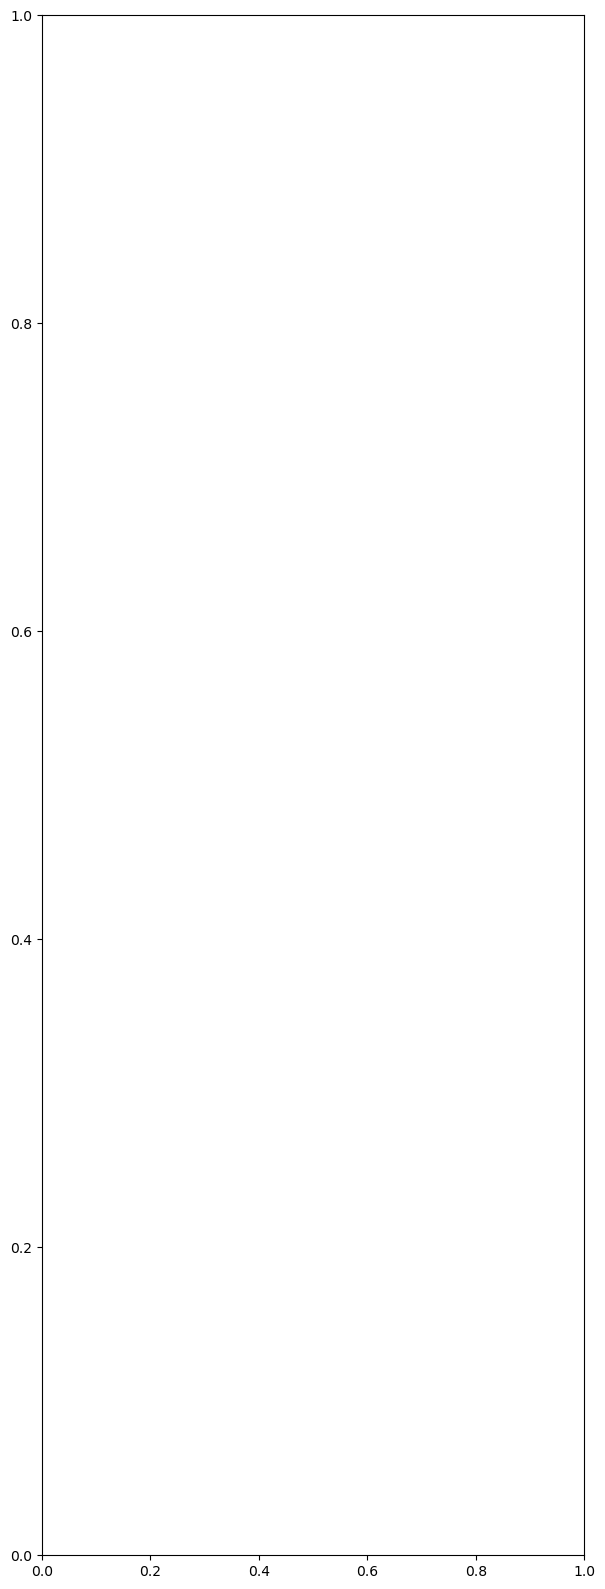

In [ ]:

# plot
fig, ax = plt.subplots(figsize=(7, 20))
plot_permutation_importance(clf_sel, X_test_important, y_test, ax)
plt.show()

# calculate metrics
print("random forest model, second iteration")
calculate_metrics(clf_sel, X_test_important, y_test)


Index(['T10YFFM', 'DMANEMP', 'USGOVT', 'CES0600000007', 'CUMFNS',
       'CAPUTLG3364T9S', 'CAPUTLG332S', 'CAPUTLG324S', 'CAPB00004S',
       'CAPG332S', 'POP', 'S&P500 Price - Inflation Adjusted',
       'Inflation Rate', 'H8B1001NCBCMG_9M_lag', 'CUSR0000SEHE_3M_lag',
       'CUUR0000SETG_6M_lag', 'WPU071201_9M_lag',
       'case Shiller Home Price Index_3M_lag'],
      dtype='object')


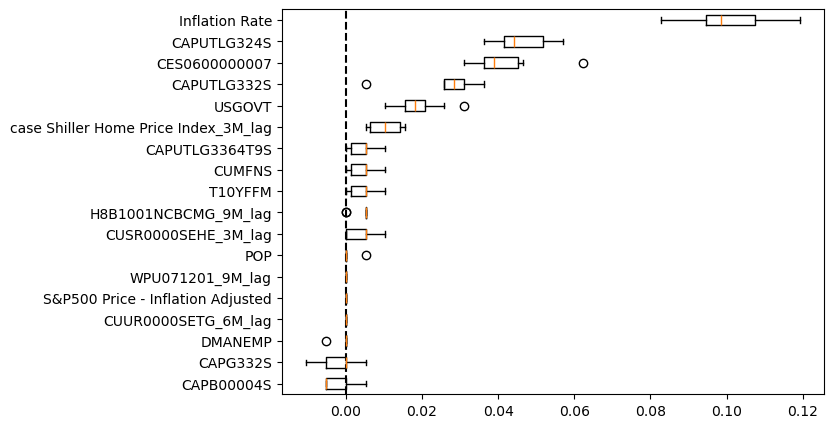

random forest model, third iteration
Recall: 0.9385
ROC AUC: 0.9999
Accuracy: 0.9793
Precision: 1.0000
F1: 0.9683


In [ ]:
perm_importance = calculate_permutation_importance(clf_sel, X_test_important, y_test)
important_features = filter_features_by_importance(X_test_important, perm_importance)
print(important_features)

X_train_important = X_train_sel[important_features]
X_test_important = X_test_sel[important_features]

clf_sel.fit(X_train_important, y_train)

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_permutation_importance(clf_sel, X_test_important, y_test, ax)
plt.show()

# calculate metrics
print("random forest model, third iteration")
calculate_metrics(clf_sel, X_test_important, y_test)

Index(['USGOVT', 'CES0600000007', 'CAPUTLG332S', 'CAPUTLG324S',
       'Inflation Rate', 'case Shiller Home Price Index_3M_lag'],
      dtype='object')


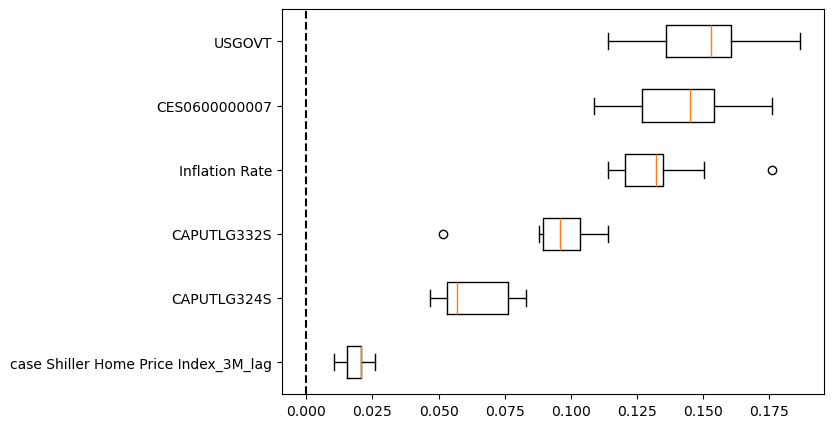

random forest model, fourth iteration
Recall: 0.9692
ROC AUC: 0.9989
Accuracy: 0.9896
Precision: 1.0000
F1: 0.9844


In [ ]:
perm_importance = calculate_permutation_importance(clf_sel, X_test_important, y_test)
important_features = filter_features_by_importance(X_test_important, perm_importance)
print(important_features)

X_train_important = X_train_sel[important_features]
X_test_important = X_test_sel[important_features]

clf_sel.fit(X_train_important, y_train)

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_permutation_importance(clf_sel, X_test_important, y_test, ax)
plt.show()

# calculate metrics
print("random forest model, fourth iteration")
calculate_metrics(clf_sel, X_test_important, y_test)

Index(['USGOVT', 'CES0600000007', 'CAPUTLG332S', 'CAPUTLG324S',
       'Inflation Rate', 'case Shiller Home Price Index_3M_lag'],
      dtype='object')


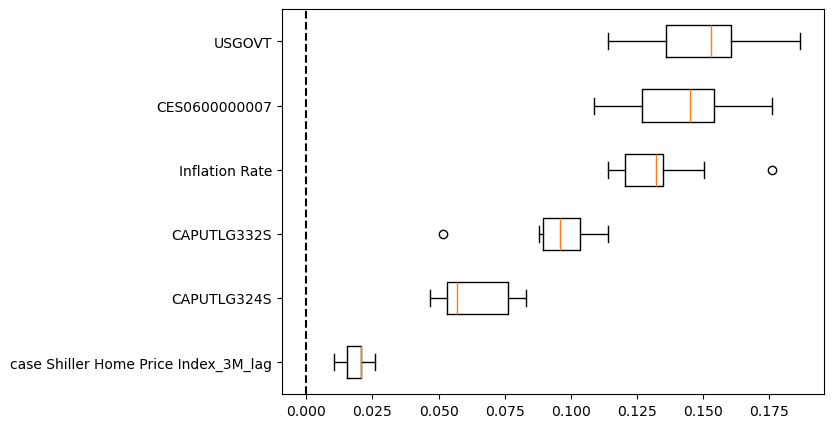

random forest model, fifth iteration
Recall: 0.9692
ROC AUC: 0.9989
Accuracy: 0.9896
Precision: 1.0000
F1: 0.9844


In [ ]:
perm_importance = calculate_permutation_importance(clf_sel, X_test_important, y_test)
important_features = filter_features_by_importance(X_test_important, perm_importance)
print(important_features)

X_train_important = X_train_sel[important_features]
X_test_important = X_test_sel[important_features]

clf_sel.fit(X_train_important, y_train)

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_permutation_importance(clf_sel, X_test_important, y_test, ax)
plt.show()

# calculate metrics
print("random forest model, fifth iteration")
calculate_metrics(clf_sel, X_test_important, y_test)

In [ ]:
# now automate for each model to get the best features for each model
# and then compare the models with the best features

